In [21]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn components
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, confusion_matrix, roc_auc_score, roc_curve,
                           classification_report)

# Utilities
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.utils.class_weight import compute_class_weight

In [23]:
# Load data
data = pd.read_csv("C:/Users/user/Downloads/EMPLOYEE_TURNOVER.csv")

# Display basic info
print("Data shape:", data.shape)
print("\nFirst 3 rows:")
display(data.head(3))

# Show column info
print("\nColumn types:")
print(data.dtypes)

# Check for missing values
print("\nMissing values:")
print(data.isnull().sum())

Data shape: (14999, 10)

First 3 rows:


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,quit,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium



Column types:
satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
quit                       int64
promotion_last_5years      int64
department                object
salary                    object
dtype: object

Missing values:
satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
quit                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64


In [35]:
# Try common target column names
target_candidates = ['Work_accident', 'quit', 'promotion_last_5years']
TARGET = None

for col in target_candidates:
    if col in data.columns:
        TARGET = col
        break

# If not found, try to create from termination date
if TARGET is None and 'termination_date' in data.columns:
    data['left'] = data['termination_date'].notna().astype(int)
    TARGET = 'left'
elif TARGET is None:
    raise ValueError("Could not identify target column. Please check your data.")

print(f"\nUsing target column: {TARGET}")
print("Class distribution:")
print(data[TARGET].value_counts(normalize=True))


Using target column: Work_accident
Class distribution:
0    0.85539
1    0.14461
Name: Work_accident, dtype: float64


In [37]:
# Separate features and target
X = data.drop(TARGET, axis=1)
y = data[TARGET]

# Convert target to binary if needed
if y.dtype == 'object':
    y = y.map({'Yes':1, 'No':0, 'Active':0, 'Terminated':1}).astype(int)

# Handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("\nData split complete:")
print(f"Train: {X_train.shape[0]} samples")
print(f"Validation: {X_val.shape[0]} samples")
print(f"Test: {X_test.shape[0]} samples")


Data split complete:
Train: 8999 samples
Validation: 3000 samples
Test: 3000 samples


In [39]:
# Identify feature types
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'bool']).columns.tolist()

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])

print("\nPreprocessing pipeline created:")
print(f"Numeric columns: {num_cols}")
print(f"Categorical columns: {cat_cols}")


Preprocessing pipeline created:
Numeric columns: ['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company', 'quit', 'promotion_last_5years']
Categorical columns: ['department', 'salary']


In [41]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(class_weight=class_weight_dict, random_state=42),
    "Decision Tree": DecisionTreeClassifier(class_weight=class_weight_dict, random_state=42),
    "Random Forest": RandomForestClassifier(class_weight=class_weight_dict, random_state=42),
    "SVM": SVC(class_weight=class_weight_dict, probability=True, random_state=42)
}

# Create pipelines
pipelines = {}
for name, model in models.items():
    pipelines[name] = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

print("\nModels initialized:")
print(list(pipelines.keys()))


Models initialized:
['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM']


In [43]:
# Train and evaluate models
results = {}
for name, pipeline in pipelines.items():
    # Training
    pipeline.fit(X_train, y_train)
    
    # Prediction
    y_pred = pipeline.predict(X_val)
    y_proba = pipeline.predict_proba(X_val)[:, 1]
    
    # Store results
    results[name] = {
        'Accuracy': accuracy_score(y_val, y_pred),
        'Precision': precision_score(y_val, y_pred),
        'Recall': recall_score(y_val, y_pred),
        'F1': f1_score(y_val, y_pred),
        'AUC': roc_auc_score(y_val, y_proba),
        'Confusion Matrix': confusion_matrix(y_val, y_pred)
    }
    
    # Print classification report
    print(f"\n{name} Classification Report:")
    print(classification_report(y_val, y_pred))

# Convert results to DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index')
print("\nModel Performance Comparison:")
display(results_df.sort_values(by='AUC', ascending=False))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.35      0.50      2566
           1       0.17      0.81      0.28       434

    accuracy                           0.41      3000
   macro avg       0.54      0.58      0.39      3000
weighted avg       0.81      0.41      0.47      3000


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      2566
           1       0.30      0.32      0.31       434

    accuracy                           0.80      3000
   macro avg       0.59      0.60      0.60      3000
weighted avg       0.80      0.80      0.80      3000


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93      2566
           1       0.89      0.18      0.31       434

    accuracy                           0.88      3000
   macro

,Accuracy,Precision,Recall,F1,AUC,Confusion Matrix
Random Forest,0.878667,0.888889,0.184332,0.305344,0.705800,"[[2556, 10], [354, 80]]"
SVM,0.470667,0.181215,0.755760,0.292335,0.618928,"[[1084, 1482], [106, 328]]"
Decision Tree,0.796333,0.304636,0.317972,0.311161,0.597607,"[[2251, 315], [296, 138]]"
Logistic Regression,0.413333,0.172754,0.806452,0.284553,0.584158,"[[890, 1676], [84, 350]]"


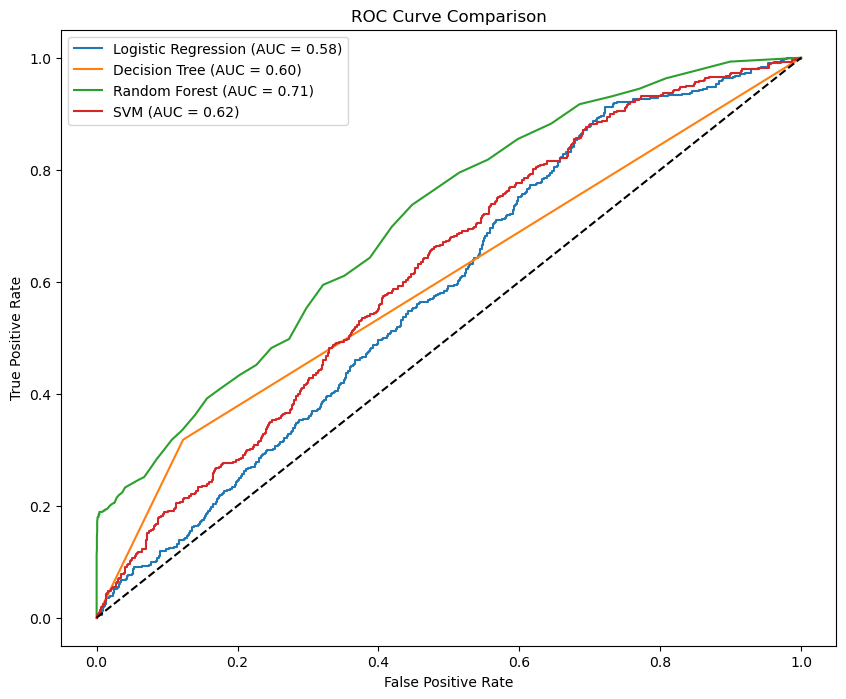

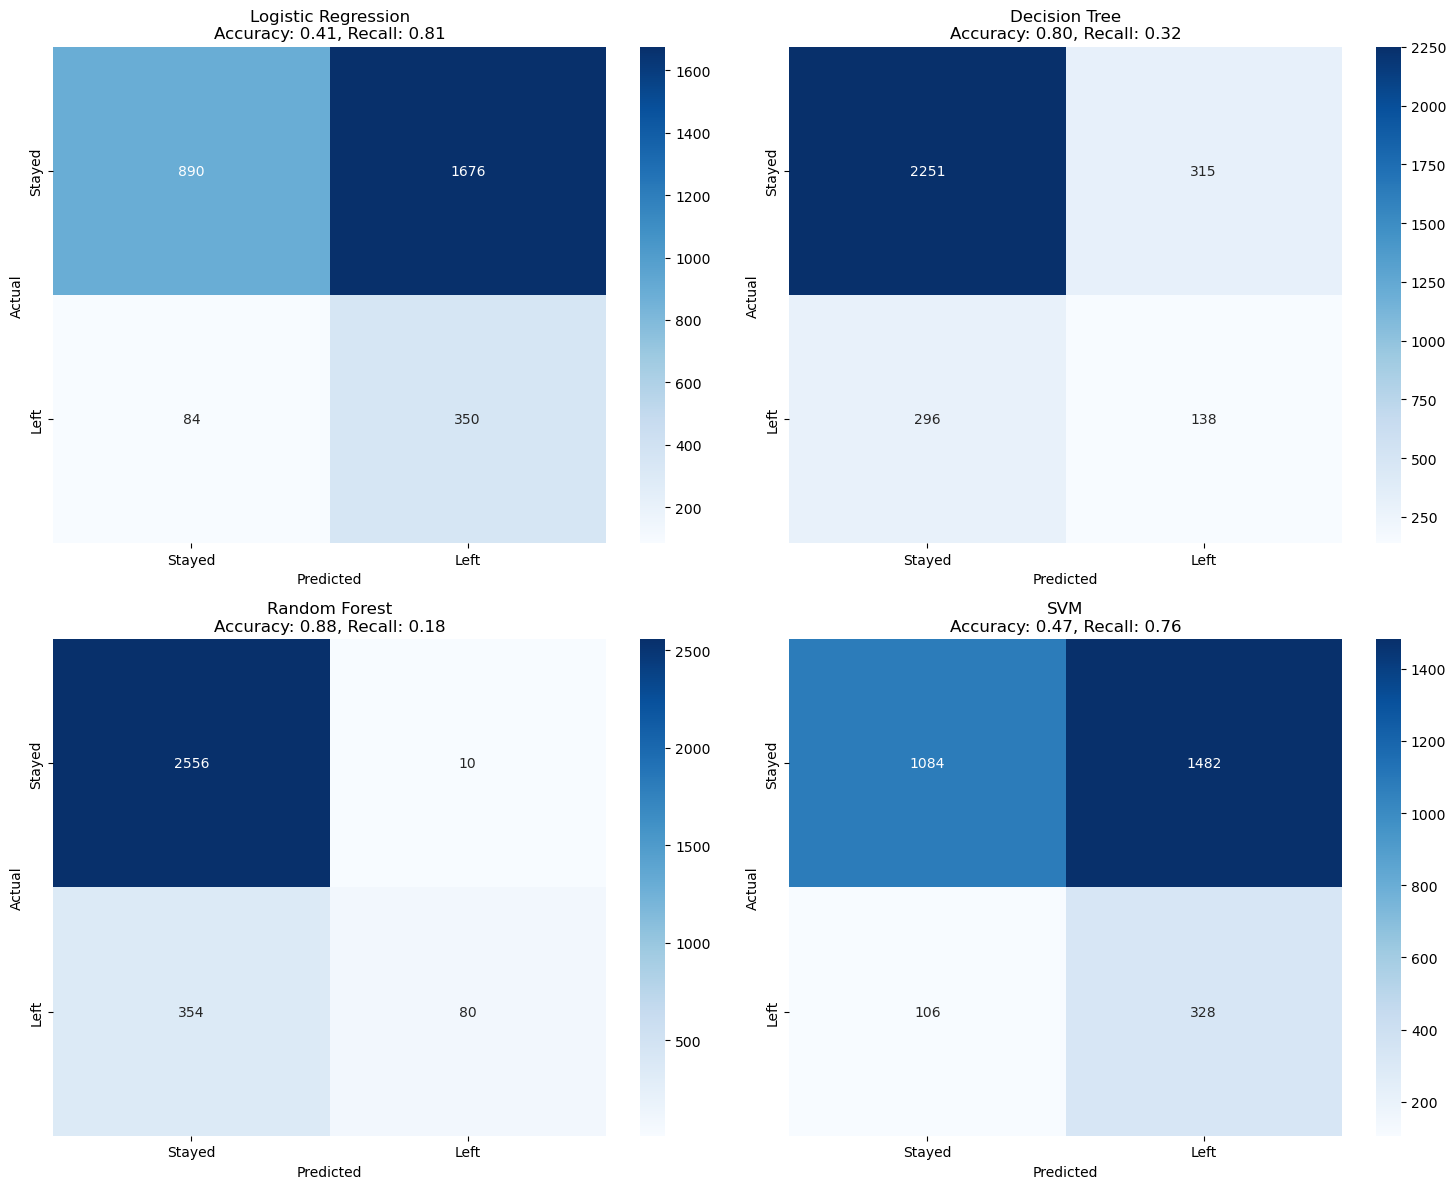

In [44]:
# ROC Curves
plt.figure(figsize=(10, 8))
for name, pipeline in pipelines.items():
    y_proba = pipeline.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {results[name]["AUC"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

# Confusion Matrices
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
for (name, result), ax in zip(results.items(), axes.ravel()):
    sns.heatmap(result['Confusion Matrix'], annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Stayed', 'Left'], yticklabels=['Stayed', 'Left'])
    ax.set_title(f'{name}\nAccuracy: {result["Accuracy"]:.2f}, Recall: {result["Recall"]:.2f}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()


Evaluating best model: Random Forest


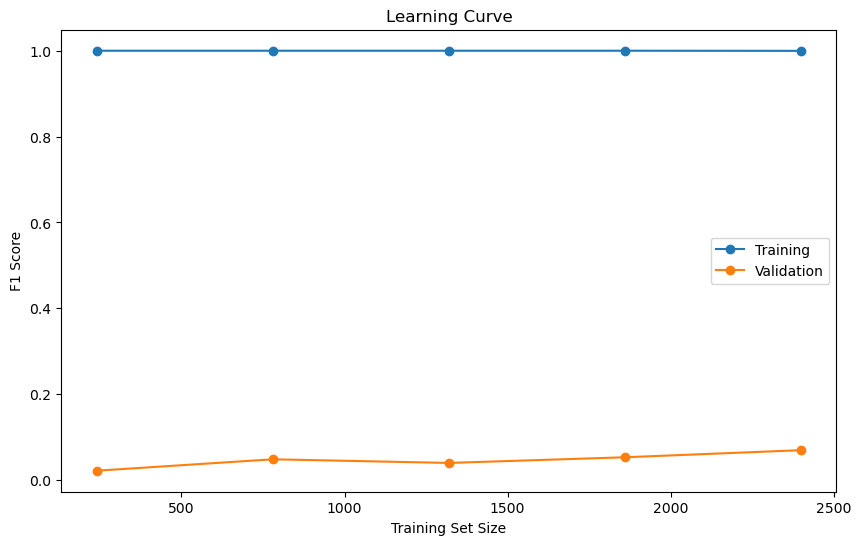

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93      2566
           1       0.89      0.18      0.31       434

    accuracy                           0.88      3000
   macro avg       0.88      0.59      0.62      3000
weighted avg       0.88      0.88      0.84      3000



In [47]:
def evaluate_model_quality(model, X, y):
    # Learning curve
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, scoring='f1',
        train_sizes=np.linspace(0.1, 1.0, 5))
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training')
    plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', label='Validation')
    plt.xlabel('Training Set Size')
    plt.ylabel('F1 Score')
    plt.title('Learning Curve')
    plt.legend()
    plt.show()
    
    # Detailed report
    y_pred = model.predict(X)
    print("Detailed Classification Report:")
    print(classification_report(y, y_pred))

# Evaluate best model
best_model_name = results_df['AUC'].idxmax()
print(f"\nEvaluating best model: {best_model_name}")
evaluate_model_quality(pipelines[best_model_name], X_val, y_val)

In [49]:
# Select best model
best_model = pipelines[best_model_name]

# Evaluate on test set
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

print("\nFinal Model Performance on Test Set:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.2f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.2f}")
print(f"F1 Score: {f1_score(y_test, y_test_pred):.2f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_test_proba):.2f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

# Feature Importance (for tree-based models)
if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    print("\nFeature Importances:")
    feature_importances = best_model.named_steps['classifier'].feature_importances_
    features = (best_model.named_steps['preprocessor']
                .named_transformers_['cat']
                .get_feature_names_out(cat_cols).tolist() + num_cols)
    
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': feature_importances
    }).sort_values('Importance', ascending=False)
    
    display(importance_df.head(10))


Final Model Performance on Test Set:
Accuracy: 0.88
Precision: 0.88
Recall: 0.18
F1 Score: 0.30
ROC AUC: 0.72

Confusion Matrix:
[[2555   11]
 [ 354   80]]

Feature Importances:


,Feature,Importance
3,department_hr,0.239578
0,department_IT,0.214448
1,department_RandD,0.206194
4,department_management,0.072992
2,department_accounting,0.068091
5,department_marketing,0.045193
14,last_evaluation,0.015821
19,promotion_last_5years,0.015552
18,quit,0.015339
16,average_montly_hours,0.014883
